# Get Movie Data

In [391]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

id_index_dict = {}  
index_id_dict = {}  
genres = [
    "Action", "Adventure", "Animation", "Children's",
    "Comedy", "Crime", "Documentary", "Drama",
    "Fantasy", "Film-Noir", "Horror", "Musical",
    "Mystery", "Romance", "Sci-Fi", "Thriller",
    "War", "Western"
]

genre_index_dict = {genre: index for index, genre in enumerate(genres)}


with open('/kaggle/input/movies/movies.dat', 'r', encoding='ISO-8859-1') as file:
    for index, line in enumerate(file):
        movie_info = line.strip().split('::') 
        movie_id = int(movie_info[0])
        movie_name = movie_info[1]
        movie_genre = movie_info[2].split('|')
        
        id_index_dict[movie_id] = (index, movie_name, movie_genre)
        index_id_dict[index] = movie_id



# Preprocess function (type 0: Shift to Mean, type 1: Standardization, type 2: Normalization Shifted to Mean)

In [392]:
def preprocess(row, type):
    non_zero_indices = np.nonzero(row) 
    zero_indices = np.where(row == 0)
    if type == 1:
        mean = np.mean(row[non_zero_indices])
        std = np.std(row[non_zero_indices])
        row[non_zero_indices] -= mean
        if std > 0:
            row[non_zero_indices] /= std
        row[zero_indices] = 0
    elif type == 0:
        mean = np.mean(row[non_zero_indices])
        row[non_zero_indices] -= mean
        row[zero_indices] = 0
    elif type == 2:
        r = np.max(row[non_zero_indices]) - np.min(row[non_zero_indices])
        if r > 0:
            row[non_zero_indices] /= r
        mean = np.mean(row[non_zero_indices])
        row[non_zero_indices] -= mean
        row[zero_indices] = 0
        

# Create User-Movie and User-Genre matrices (30s estimated time)

In [393]:
USER_CNT = 4832
MOVIE_CNT = 3883
GENRE_CNT = 18

TEST_CNT = 6040 - USER_CNT
METRIC = 1

ratings_matrix = np.zeros((USER_CNT, MOVIE_CNT), dtype=float)
cnt_genre = np.zeros((USER_CNT, GENRE_CNT))
cnt_test = np.zeros((TEST_CNT, GENRE_CNT))
cnt_movies = np.zeros(MOVIE_CNT)
genre_matrix = np.zeros((USER_CNT, GENRE_CNT), dtype = float)
genre_test = np.zeros((TEST_CNT, GENRE_CNT), dtype = float)

test_data = np.zeros((TEST_CNT, MOVIE_CNT), dtype=float)

print("Creating ratings matrix")
        
with open('/kaggle/input/movies/ratings.dat', 'r') as file:
    for line in file:
        user_id, movie_id, rating, timestamp = map(int, line.strip().split('::'))
    
        user_index = user_id - 1
        movie_index = id_index_dict[movie_id][0]
        movie_genre = id_index_dict[movie_id][2]
        
        if user_index >= USER_CNT:
            test_data[user_index-USER_CNT, movie_index] = rating
            for genre in movie_genre:
                cnt_test[user_index-USER_CNT][genre_index_dict[genre]] += 1
            continue
        
        ratings_matrix[user_index, movie_index] = rating
        cnt_movies[movie_index] += 1
        
        for genre in movie_genre:
            cnt_genre[user_index][genre_index_dict[genre]] += 1
            
mask = (cnt_movies != 0)
weights = np.zeros(MOVIE_CNT, dtype = float)
weights[mask] = np.log(USER_CNT / cnt_movies[mask])

test_mask = []
for i in range(TEST_CNT):
    test_mask.append((test_data[i, :] != 0))

for i in range(USER_CNT):
    preprocess(ratings_matrix[i, :], 0)
    ratings_matrix[i, :] *= weights
    
for i in range(TEST_CNT):
    preprocess(test_data[i, :], 0)

print("Creating genre matrix")
    
for i in range(USER_CNT):
    non_zero_indices = np.nonzero(ratings_matrix[i, :])[0]
    vals = ratings_matrix[i, non_zero_indices]
    
    ids = [index_id_dict[j] for j in non_zero_indices]
    movie_genres = [id_index_dict[id][2] for id in ids]
    
    for val, genres in zip(vals, movie_genres):
        genre_indices = [genre_index_dict[genre] for genre in genres]
        genre_matrix[i, genre_indices] += val
            
mask = (cnt_genre != 0)
genre_matrix[mask] /= cnt_genre[mask]

for i in range(TEST_CNT):
    non_zero_indices = np.nonzero(test_data[i, :])[0]
    vals = test_data[i, non_zero_indices]
    
    ids = [index_id_dict[j] for j in non_zero_indices]
    movie_genres = [id_index_dict[id][2] for id in ids]
    
    for val, genres in zip(vals, movie_genres):
        genre_indices = [genre_index_dict[genre] for genre in genres]
        genre_test[i, genre_indices] += val
        
mask = (cnt_test != 0)
genre_test[mask] /= cnt_test[mask]

print(test_data)

#np.savetxt('/kaggle/working/ratings_matrix.csv', ratings_matrix, delimiter = ',')
#np.savetxt('/kaggle/working/genre_matrix.csv', genre_matrix, delimiter = ',')

Creating ratings matrix
Creating genre matrix
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.62857143  0.37142857  0.         ...  0.          0.
   0.37142857]
 [ 1.27710843  0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.57771261  0.          0.         ...  0.          0.
   0.        ]]


# EDA


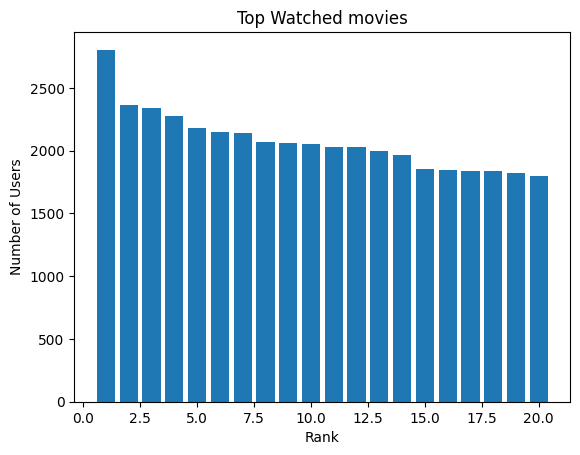

[2858, 260, 1196, 1210, 480, 2028, 589, 2571, 593, 1580, 1270, 110, 608, 1198, 2762, 527, 2396, 1197, 1617, 1265]
[0.54385692 0.7161752  0.72468227 0.75415992 0.79547697 0.80979262
 0.81538965 0.84916218 0.85352582 0.85644553 0.8677174  0.8677174
 0.88311378 0.89722692 0.95737576 0.96386578 0.96603852 0.96658244
 0.97422857 0.98691839]


In [394]:
top = np.argsort(cnt_movies)[-20:][::-1]

plt.bar(range(1, 21), cnt_movies[top])
plt.xlabel('Rank')
plt.ylabel('Number of Users')
plt.title('Top Watched movies')
plt.show()

movie_ids = [index_id_dict[i] for i in top]
print(movie_ids)
print(weights[top])

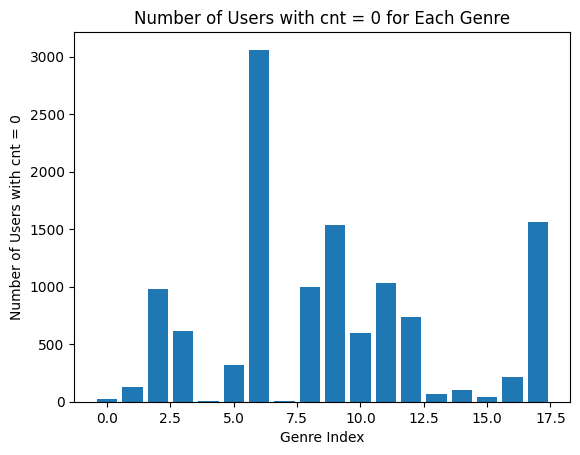

In [395]:
users_with_cnt_zero = np.sum(cnt_genre == 0, axis=0)

plt.bar(range(len(users_with_cnt_zero)), users_with_cnt_zero)
plt.xlabel('Genre Index')
plt.ylabel('Number of Users with cnt = 0')
plt.title('Number of Users with cnt = 0 for Each Genre')
plt.show()


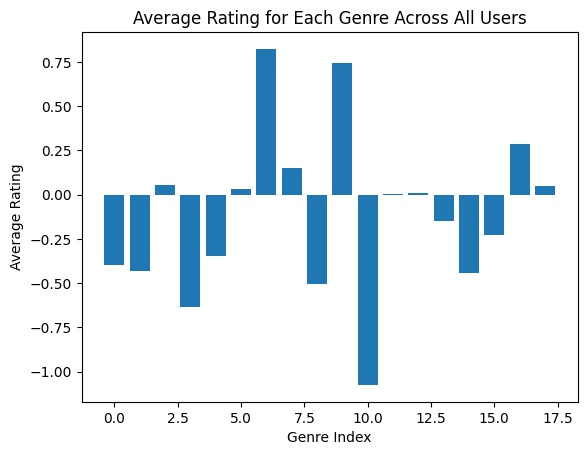

In [396]:
average_ratings = np.sum(genre_matrix * cnt_genre, axis=0) / np.sum(cnt_genre, axis=0)

# Plot a histogram
plt.bar(range(len(average_ratings)), average_ratings)
plt.xlabel('Genre Index')
plt.ylabel('Average Rating')
plt.title('Average Rating for Each Genre Across All Users')
plt.show()


# K-Means++ initialization algorithm

In [397]:
def init_kmeans(A, k, p, metric = 0):
    if p >= A.shape[0]:
        raise ValueError("Initial starting point 'p' should be within the bounds of matrix 'A'")
    centroids = []
    centroids.append(A[p, :])
    np.random.seed(42) 

    while len(centroids) < k:
        if metric == 0:
            min_distances = np.min(norm(A[:, np.newaxis, :] - centroids, axis=2), axis=1)
        else:
            dot_products = np.dot(A, np.array(centroids).T)
            norm_A = np.linalg.norm(A, axis=1)
            norm_centroids = np.linalg.norm(centroids, axis=1)
            cosine_similarity = dot_products / (np.outer(norm_A, norm_centroids) + 1e-8)  # Adding small epsilon to avoid division by zero
            min_distances = 1 - np.max(cosine_similarity, axis=1)
            
        probabilities = min_distances / np.sum(min_distances)
        chosen_index = np.random.choice(len(min_distances), p=probabilities)
        new_row_index = np.argmax(min_distances)
        new_row = A[new_row_index, :]
        
        centroids.append(new_row)
    
    return np.array(centroids)



# K-Means centroid allocation algorithm 

In [398]:
def kmeans(A, centroids, max_iter = 100, metric = 0):
    num_rows = A.shape[0]
    cluster_assignments = np.full(num_rows, -1, dtype=int)
    
    for iteration in range(max_iter):
        
        if metric == 0:
            distances = np.array([norm(A - centroid, axis=1) for centroid in centroids]).T
        else:
            dot_products = np.dot(A, np.array(centroids).T)
            norm_A = norm(A, axis=1)
            norm_centroids = norm(centroids, axis=1)
            cosine_similarity = dot_products / (np.outer(norm_A, norm_centroids) + 1e-8) 
            distances = 1 - cosine_similarity
            
        cluster_assignments = np.argmin(distances, axis=1)

        if iteration > 0 and np.array_equal(cluster_assignments, prev_cluster_assignments):
            print(f"Converged after {iteration} iterations.")
            break

        prev_cluster_assignments = cluster_assignments.copy()
        centroids = [np.mean(A[cluster_assignments == j, :], axis=0) for j in range(len(centroids))]
    
    return cluster_assignments, centroids

# K-Means test

Converged after 8 iterations.
[array([0.15970061, 0.67662726]), array([0.6321511 , 0.19671962]), array([0.62305887, 0.61938047])]


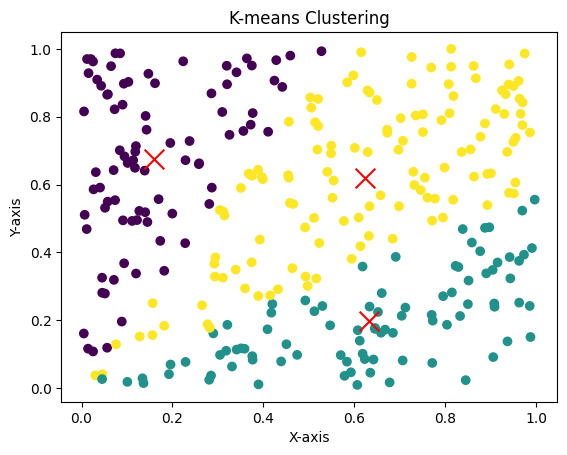

In [399]:
import matplotlib.pyplot as plt

np.random.seed(42)
points = np.random.rand(300, 2)
initial_centroids = init_kmeans(points, 3, 0, METRIC)
max_iterations = 100

cluster_assignments, final_centroids = kmeans(points, initial_centroids, max_iterations, METRIC)
print(final_centroids)
centroid_x = [centroid[0] for centroid in final_centroids]
centroid_y = [centroid[1] for centroid in final_centroids]

plt.scatter(points[:, 0], points[:, 1], c=cluster_assignments, cmap='viridis', marker='o', label='Points')
plt.scatter(centroid_x, centroid_y, c='red', marker='x', s=200, label='Centroids')
plt.title('K-means Clustering')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


# Elbow Graph plotter

In [400]:
import matplotlib.pyplot as plt


def elbow(A, k_values, metric = 0, p = 0):
    inertia = []
    initial_centroids = init_kmeans(A, k_values[-1], p, metric)
    
    for k in k_values:
        cluster_assignments, final_centroids = kmeans(A, initial_centroids[:k], 100, metric)

        sum_distances = 0
        for i in range(0, len(A)):
            p1 = A[i, :]
            p2 = final_centroids[cluster_assignments[i]]
            if metric == 0:
                sum_distances += norm(p1 - p2)**2
            else:
                num = np.dot(p1, p2)
                den = norm(p1) * norm(p2)
                if den != 0:
                    sum_distances += (1-(num/den))**2
            
        inertia.append(sum_distances)

    plt.plot(k_values, inertia, marker='o')
    plt.title('Sum of Squared Distances vs. Number of Centroids (k)')
    plt.xlabel('Number of Centroids (k)')
    plt.ylabel('Sum of Squared Distances')
    plt.show()

# Power Iteration for SVD

In [401]:
def power_iteration(A, max_iter = 100, epsilon = 1e-6):
    n = A.shape[0]
    curr = np.random.rand(n)
    curr = curr / norm(curr)

    for i in range(0, max_iter):
        next = np.dot(A, curr)
        val = norm(next)
        if val < epsilon:
            return np.zeros(n)
        next = next / val
        if abs(np.dot(next, curr)) > 1 - epsilon:
            break
        curr = next

    #val = np.dot(curr.T, np.dot(A, curr)) / np.dot(curr.T, curr)
    #print(val**0.5)
    
    return curr


# SVD (Returns matrices U, Sigma, and V transpose)

In [402]:
def SVD(mat, k = 100, max_iter = 100, epsilon = 1e-6):
    n, m = mat.shape
    if k > min(n, m):
        k = min(n, m)

    ulist = []
    vlist = []
    slist = []
    A = mat.copy()

    for i in range(0, k):
        print("Iteration: " + str(i+1))
        if n <= m:
            S = np.dot(A, A.T)
            u = power_iteration(S, max_iter, epsilon)
            if np.all(u == 0):
                break
            v = np.dot(mat.T, u)
            s = norm(v)
            v = v / s
        else:
            S = np.dot(A.T, A)
            v = power_iteration(S, max_iter, epsilon)
            if np.all(v == 0):
                break
            u = np.dot(mat, v)
            s = norm(u)
            u = u / s
        A -= s * np.outer(u, v)
        ulist.append(u)
        vlist.append(v)
        slist.append(s)

    while len(ulist) < n:
        ulist.append(np.zeros(n))

    while len(vlist) < m:
        vlist.append(np.zeros(m))

    U = (np.vstack(ulist)).T
    Vt = np.vstack(vlist)
    Sigma = np.zeros((n, m))
    for i in range(0, len(slist)):
        Sigma[i, i] = slist[i]
        
    return U, Sigma, Vt

def addRow(U, Sigma, V, r):
    u = np.dot(r, V)
    non_zero = np.where(np.diag(Sigma) != 0)[0]
    u[non_zero] /= np.diag(Sigma)[non_zero]
    if len(U) > len(u):
        u = np.concatenate([u, np.zeros(len(U) - len(u))])
    u = u[:len(U)]
    U = np.vstack([U, u])
    return U

# SVD test

In [403]:
float_matrix = np.random.rand(7, 5)
print(float_matrix)

U, Sigma, Vt = SVD(float_matrix)
print(Sigma)
reduced_matrix = np.dot(U, np.dot(Sigma, Vt))
print(reduced_matrix)

[[0.73199394 0.59865848 0.15601864 0.15599452 0.05808361]
 [0.86617615 0.60111501 0.70807258 0.02058449 0.96990985]
 [0.83244264 0.21233911 0.18182497 0.18340451 0.30424224]
 [0.52475643 0.43194502 0.29122914 0.61185289 0.13949386]
 [0.29214465 0.36636184 0.45606998 0.78517596 0.19967378]
 [0.51423444 0.59241457 0.04645041 0.60754485 0.17052412]
 [0.06505159 0.94888554 0.96563203 0.80839735 0.30461377]]
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
[[2.7723674  0.         0.         0.         0.        ]
 [0.         1.17091837 0.         0.         0.        ]
 [0.         0.         0.84633651 0.         0.        ]
 [0.         0.         0.         0.43434503 0.        ]
 [0.         0.         0.         0.         0.24349322]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.73199394 0.59865848 0.15601864 0.15599452 0.05808361]
 [0.86617615 0.60111501 0.70807258 0.02058449 0.96990985]
 [0.8

# PCA 

In [404]:
def PCA(X):
     
    X_meaned = X - np.mean(X , axis = 0)
     
    cov_mat = np.cov(X_meaned , rowvar = False)
     
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    eigenvector_subset = sorted_eigenvectors[:,:]
     
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
     
    return X_reduced

# PCA test

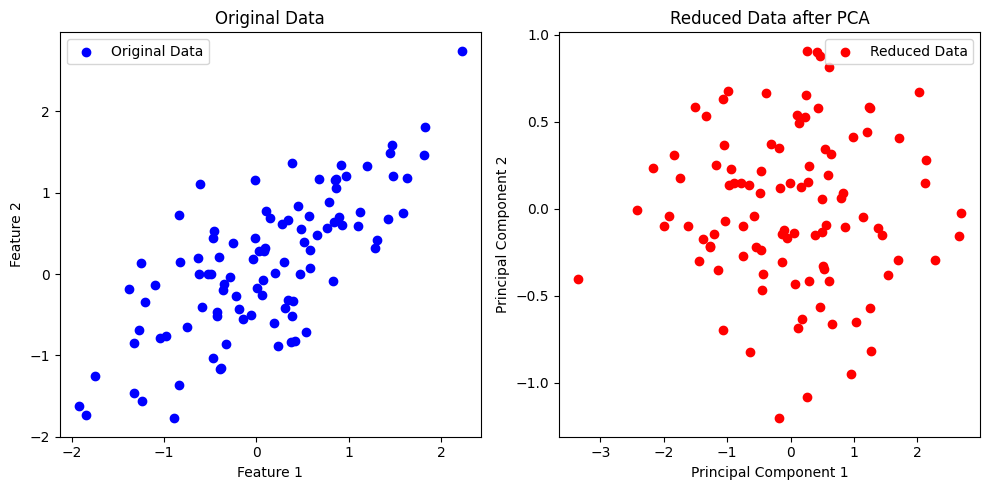

In [415]:
np.random.seed(42)
data = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.8], [0.8, 1]], size=100)

reduced_data = PCA(data)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], c='blue', label='Original Data')
plt.title('Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='red', label='Reduced Data')
plt.title('Reduced Data after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

plt.tight_layout()
plt.show()


# Get reduced Genre Matrix

In [405]:
U, Sigma, Vt = SVD(genre_matrix, 12)
reduced_genre_matrix = np.dot(U, np.dot(Sigma, Vt))

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12


# Plot Elbow Graph for reduced Genre Matrix

Converged after 1 iterations.
Converged after 17 iterations.
Converged after 34 iterations.
Converged after 33 iterations.
Converged after 44 iterations.
Converged after 26 iterations.
Converged after 26 iterations.
Converged after 24 iterations.
Converged after 45 iterations.
Converged after 74 iterations.
Converged after 63 iterations.
Converged after 47 iterations.
Converged after 32 iterations.
Converged after 26 iterations.
Converged after 24 iterations.
Converged after 25 iterations.
Converged after 37 iterations.
Converged after 49 iterations.
Converged after 52 iterations.


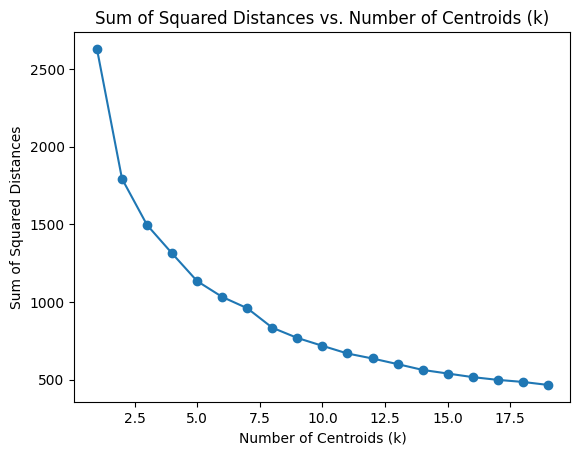

In [406]:
elbow(reduced_genre_matrix, range(1, 20), METRIC)

# Get clusters for the reduced Genre Matrix. (Number of clusers is chosen based on elbow plot above)


In [407]:
initial_centroids = init_kmeans(reduced_genre_matrix, 18, 0, METRIC)
assignment, centroids = kmeans(reduced_genre_matrix, initial_centroids, 100, METRIC)
centroid_matrix = np.vstack(centroids)

Converged after 49 iterations.


# Take average ratings of users in each cluster

In [408]:
averages = []
for cluster in range(0, len(centroids)):
    cluster_indices = [i for i, c in enumerate(assignment) if c == cluster]
    cluster_ratings = ratings_matrix[cluster_indices, :]
    average_row = np.mean(cluster_ratings, axis=0)
    averages.append(average_row)
    
    print("Cluster " + str(cluster))
    print(len(cluster_indices))
    print(np.argsort(centroids[cluster]))
    top_indices = np.argsort(average_row)[-10:][::-1]
    for i in top_indices:
        genres = ""
        for genre in id_index_dict[index_id_dict[i]][2]:
            genres += genre + ","
        print(id_index_dict[index_id_dict[i]][1] + " | " + genres)
        print(average_row[i])
    print("")

avg_matrix = np.vstack(averages)

Cluster 0
157
[13  4  7  1  0 12 10  6  8 16 17 15  2 11 14  5  3  9]
Animal House (1978) | Comedy,
0.18451077969104884
Godfather, The (1972) | Action,Crime,Drama,
0.17881954867579833
Gladiator (2000) | Action,Drama,
0.16986786813685062
Godfather: Part II, The (1974) | Action,Crime,Drama,
0.16955947451472178
Star Wars: Episode IV - A New Hope (1977) | Action,Adventure,Fantasy,Sci-Fi,
0.1664863269622631
Pulp Fiction (1994) | Crime,Drama,
0.16373634477083282
Usual Suspects, The (1995) | Crime,Thriller,
0.16367626559220047
Silence of the Lambs, The (1991) | Drama,Thriller,
0.16207445102335274
Jaws (1975) | Action,Horror,
0.15810236578766262
Exorcist, The (1973) | Horror,
0.15162590435258033

Cluster 1
183
[ 3  1  8 14  0 11  4 17  2 16 13  6  7 10 15  5  9 12]
Maltese Falcon, The (1941) | Film-Noir,Mystery,
0.39180104318513304
Big Sleep, The (1946) | Film-Noir,Mystery,
0.31615008305647885
Arsenic and Old Lace (1944) | Comedy,Mystery,Thriller,
0.3124039421862598
Rear Window (1954) | Myster

In [409]:
def test(test, A, centroids, avg, metric = 0):
    num_rows = A.shape[0]
    cluster_assignments = np.full(num_rows, -1, dtype=int)
    
    if metric == 0:
        distances = np.array([norm(A - centroid, axis=1) for centroid in centroids]).T
    else:
        dot_products = np.dot(A, np.array(centroids).T)
        norm_A = norm(A, axis=1)
        norm_centroids = norm(centroids, axis=1)
        cosine_similarity = dot_products / (np.outer(norm_A, norm_centroids) + 1e-8) 
        distances = 1 - cosine_similarity

    cluster_assignments = np.argmin(distances, axis=1)
    
    MSE = 0
    total = 0
    for i in range(num_rows):
        mask = test_mask[i]
        p1 = test[i, mask]
        p2 = avg[cluster_assignments[i]]
        p2 = p2[mask]
        MSE += np.sum((p1-p2)**2)
        total += np.count_nonzero(mask)
        
    MSE /= total
    return MSE
        

## Get mean square error against test data

In [410]:
test(test_data, genre_test, centroid_matrix, avg_matrix, METRIC)

0.977685948211284

In [411]:
user = np.zeros(MOVIE_CNT)
user_genre = np.zeros(GENRE_CNT, dtype = float)
user_cnt = np.zeros(GENRE_CNT, dtype = float)
ids = set()
while True:
    print("Enter the movie ID or -1 to get predictions")
    c = int(input())
    if c == -1:
        break
    print("Selected " + id_index_dict[c][1])
    print("Enter rating (1-5)")
    r = int(input())
    user[id_index_dict[c][0]] = r
    ids.add(c)

for i in range(MOVIE_CNT):
    if user[i] == 0:
        continue
    movie_genre = id_index_dict[index_id_dict[i]][2]
    for genre in movie_genre:
        user_cnt[genre_index_dict[genre]] += 1
    
preprocess(user, 0)

for i in range(MOVIE_CNT):
    if user[i] == 0:
        continue
    movie_genre = id_index_dict[index_id_dict[i]][2]
    for genre in movie_genre:
        user_genre[genre_index_dict[genre]] += user[i]

mask = (user_cnt != 0)
user_genre[mask] /= user_cnt[mask]
print(user_genre)
    
if METRIC == 0:
    distances = norm(centroid_matrix - user_genre, axis=1)
else:
    dot_products = np.dot(centroid_matrix, user_genre)
    norms_centroid = norm(centroid_matrix, axis=1)
    norm_user = norm(user_genre)
    distances = 1 - dot_products / (norms_centroid * norm_user + 1e-8)

    
    
clusterID = np.argmin(distances)
print("Allocated cluster: " + str(clusterID))

top = np.argsort(avg_matrix[clusterID, :])[::-1]

print("Recommended Movies")
rec = []
for i in top:
    id = index_id_dict[i]
    if id in ids:
        continue
    ids.add(id)
    genres = ""
    for genre in id_index_dict[id][2]:
        genres += genre + ","
    rec.append(id_index_dict[id][1] + " | " + genres)
    if len(rec) > 10:
        break

for s in rec:
    print(s)

Enter the movie ID or -1 to get predictions


KeyboardInterrupt: Interrupted by user

# Find best hyperparameters for SVD and K-Means

In [ ]:
vals = []

for parameter in range(2, 18):
    U, Sigma, Vt = SVD(genre_matrix, parameter)
    reduced_genre_matrix = np.dot(U, np.dot(Sigma, Vt))
    initial_centroids = init_kmeans(reduced_genre_matrix, 18, 0, METRIC)
    assignment, centroids = kmeans(reduced_genre_matrix, initial_centroids, 100, METRIC)
    centroid_matrix = np.vstack(centroids)

    averages = []
    for cluster in range(0, len(centroids)):
        cluster_indices = [i for i, c in enumerate(assignment) if c == cluster]
        cluster_ratings = ratings_matrix[cluster_indices, :]
        average_row = np.mean(cluster_ratings, axis=0)
        averages.append(average_row)

    avg_matrix = np.vstack(averages)
    val = test(test_data, genre_test, centroid_matrix, avg_matrix, METRIC)
    vals.append(val)

plt.plot(range(2, 18), vals, marker='o') 
plt.xlabel('Parameter')
plt.ylabel('Mean Square Error')
plt.title('Optimal Reduced SVD')
plt.show()

# Reduction using PCA

In [414]:
reduced_genre_matrix = PCA(genre_matrix)
initial_centroids = init_kmeans(reduced_genre_matrix, 18, 0, METRIC)
assignment, centroids = kmeans(reduced_genre_matrix, initial_centroids, 100, METRIC)
centroid_matrix = np.vstack(centroids)

averages = []
for cluster in range(0, len(centroids)):
    cluster_indices = [i for i, c in enumerate(assignment) if c == cluster]
    cluster_ratings = ratings_matrix[cluster_indices, :]
    average_row = np.mean(cluster_ratings, axis=0)
    averages.append(average_row)

avg_matrix = np.vstack(averages)
val = test(test_data, genre_test, centroid_matrix, avg_matrix, METRIC)
print(val)

Converged after 32 iterations.
1.0233205132375414
